In [21]:
# Import my .py code 
# Run this to reimport without having to restart the whole notebook
import calibration_functions
import importlib
importlib.reload(calibration_functions)
from calibration_functions import *

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tqdm as tqdm
import pandas as pd

plt.rcParams['font.size'] = 16
plt.rc("font", family="serif")

In [33]:
filename = r"expres_tp/LFC_200907.1063.fits"
hdu1 = fits.open(filename)
data = hdu1[1].data.copy()

def compute_chi2s(uncertainty_factor = 1):
    chi2vals = []
    probs = []
    for order in tqdm.tqdm(np.arange(len(data))):
        data_spec       = data['spectrum'][order]
        data_spec_err   = data['uncertainty'][order] * uncertainty_factor
        
        # Find peaks
        peak_info = func_find_peaks(data_spec, 11, 0.15)
        peak_locs = peak_info[0]

        if len(peak_locs) < 10:
            continue

        # Create data slices around each peak
        peak_index_ranges = get_peak_index_ranges(peak_locs)

        # Fit peak in each data slice
        peak_fits = fit_peaks(data_spec, data_spec_err, peak_index_ranges)

        # Get chi2 and prop
        chi2vals.append(peak_fits[:, 8])
        probs.append(peak_fits[:, 13])

    # Flatten
    chi2vals = np.concatenate(chi2vals)
    probs = np.concatenate(probs)
    return chi2vals, probs

In [34]:
results_1 = compute_chi2s()
results_2 = compute_chi2s(np.sqrt(3))
results_3 = compute_chi2s(np.sqrt(10))

  0%|          | 0/86 [00:00<?, ?it/s]/Users/jakobharteg/GitHub/bachelor-project/calibration_functions.py:97: RuntimeWarning: overflow encountered in power
  return A * np.exp(-z**P) + C + b * (x - mu)
/Users/jakobharteg/GitHub/bachelor-project/calibration_functions.py:97: RuntimeWarning: divide by zero encountered in power
  return A * np.exp(-z**P) + C + b * (x - mu)
100%|██████████| 86/86 [00:53<00:00,  1.59it/s]


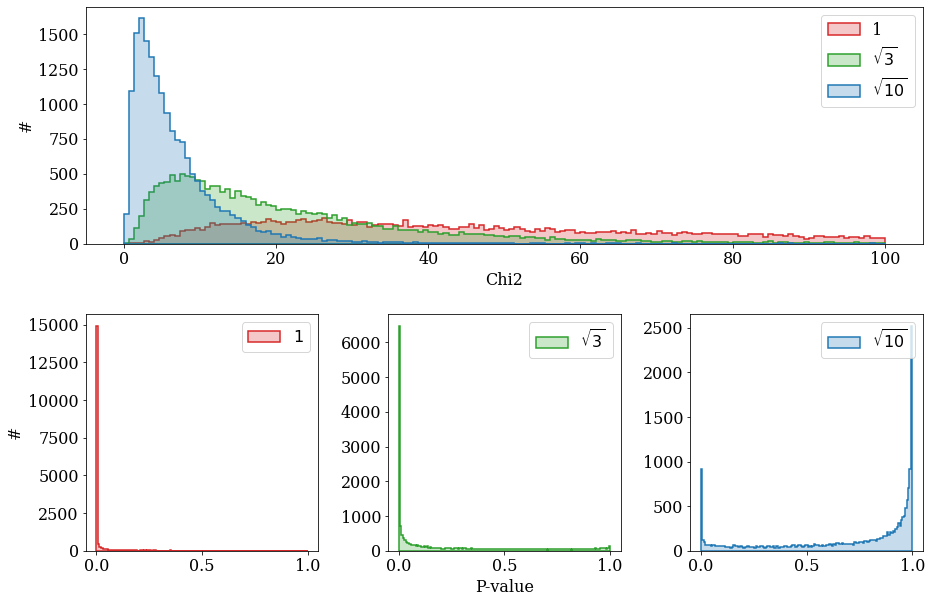

In [147]:
from matplotlib import colors
nbins = 150
range = (0, 100)


plt.figure(figsize = (15, 10))
grid = plt.GridSpec(2, 3, wspace=0.3, hspace=0.3)
ax1 = plt.subplot(grid[0, :3])  # wide top plot
ax2 = plt.subplot(grid[1, 0])   # |
ax3 = plt.subplot(grid[1, 1])   # | Three cols on the second row
ax4 = plt.subplot(grid[1, 2])   # |


# fig, ax1 = plt.subplots(figsize=(15,5))
ax1.hist(results_1[0], bins=nbins, range=range, histtype="stepfilled", facecolor=colors.to_rgba('C3', 0.25), edgecolor="C3", lw=1.5, label="1");
ax1.hist(results_2[0], bins=nbins, range=range, histtype="stepfilled", facecolor=colors.to_rgba('C2', 0.25), edgecolor="C2", lw=1.5, label="$\sqrt{3}$");
ax1.hist(results_3[0], bins=nbins, range=range, histtype="stepfilled", facecolor=colors.to_rgba('C0', 0.25), edgecolor="C0", lw=1.5, label="$\sqrt{10}$");
ax1.set_xlabel("Chi2")
ax1.set_ylabel("#")
ax1.legend(loc="upper right")


range = (0, 1)

ax2.hist(results_1[1], bins=nbins, range=range, histtype="stepfilled", facecolor=colors.to_rgba('C3', 0.25), edgecolor="C3", lw=1.5, label="$1$");
ax2.set_ylabel("#")
ax2.legend(loc="upper right")

ax3.hist(results_2[1], bins=nbins, range=range, histtype="stepfilled", facecolor=colors.to_rgba('C2', 0.25), edgecolor="C2", lw=1.5, label="$\sqrt{3}$");
ax3.legend(loc="upper right")
ax3.set_xlabel("P-value")

ax4.hist(results_3[1], bins=nbins, range=range, histtype="stepfilled", facecolor=colors.to_rgba('C0', 0.25), edgecolor="C0", lw=1.5, label="$\sqrt{10}$");
ax4.legend(loc="upper right")

The chi2 values should be equal to the number of parameters in the fit. We have 5 parameters (although Troels said something about 12 or 14 .... why?). So we can see that the initial errors give a chi2 distribution that is waaay to flat. If we multiply by $\sqrt{3}$ we get something better. $\sqrt{10}$ looks perhaps even better! But, the p-value distribution should be flat (TODO: ask Troels why or look it up), so we can see that the original errors are probably too small and the ones multiplied by $\sqrt{10}$ are too high, because we get a spike at 1 — i.e. the fit is too good. The spike at 0 is okay, those are just all the fits that sucked and should perhaps be removed. 

Troels init suggestion to do this is here: https://mail.google.com/mail/u/0/?ui=2&view=btop&ver=ops2cvpehp6&cat=BSc&qid=99FD73A2-0ECF-4EF1-A8F9-58B18FCC72FD&search=cat&th=%23thread-f%3A1724470506419210702&cvid=1

He said: 

The Chi2 values are about a factor 3 too larger, thus the uncertainties are about a factor sqrt(3) too small. My evaluation is based on the notion, that the Prob-distribution should be about flat, when it is right (with peaks at the ends). We then seem to have a good fraction (10%?), which are poor fits, perhaps to be considered either for omission or increased uncertainty.



In [111]:
# Let's try some other values

results_4 = compute_chi2s(np.sqrt(4))
results_5 = compute_chi2s(np.sqrt(5))
results_6 = compute_chi2s(np.sqrt(6))
results_7 = compute_chi2s(np.sqrt(7))
results_8 = compute_chi2s(np.sqrt(8))
results_9 = compute_chi2s(np.sqrt(9))


  0%|          | 0/86 [00:00<?, ?it/s]/Users/jakobharteg/GitHub/bachelor-project/calibration_functions.py:97: RuntimeWarning: overflow encountered in power
  return A * np.exp(-z**P) + C + b * (x - mu)
/Users/jakobharteg/GitHub/bachelor-project/calibration_functions.py:97: RuntimeWarning: divide by zero encountered in power
  return A * np.exp(-z**P) + C + b * (x - mu)
100%|██████████| 86/86 [00:54<00:00,  1.59it/s]


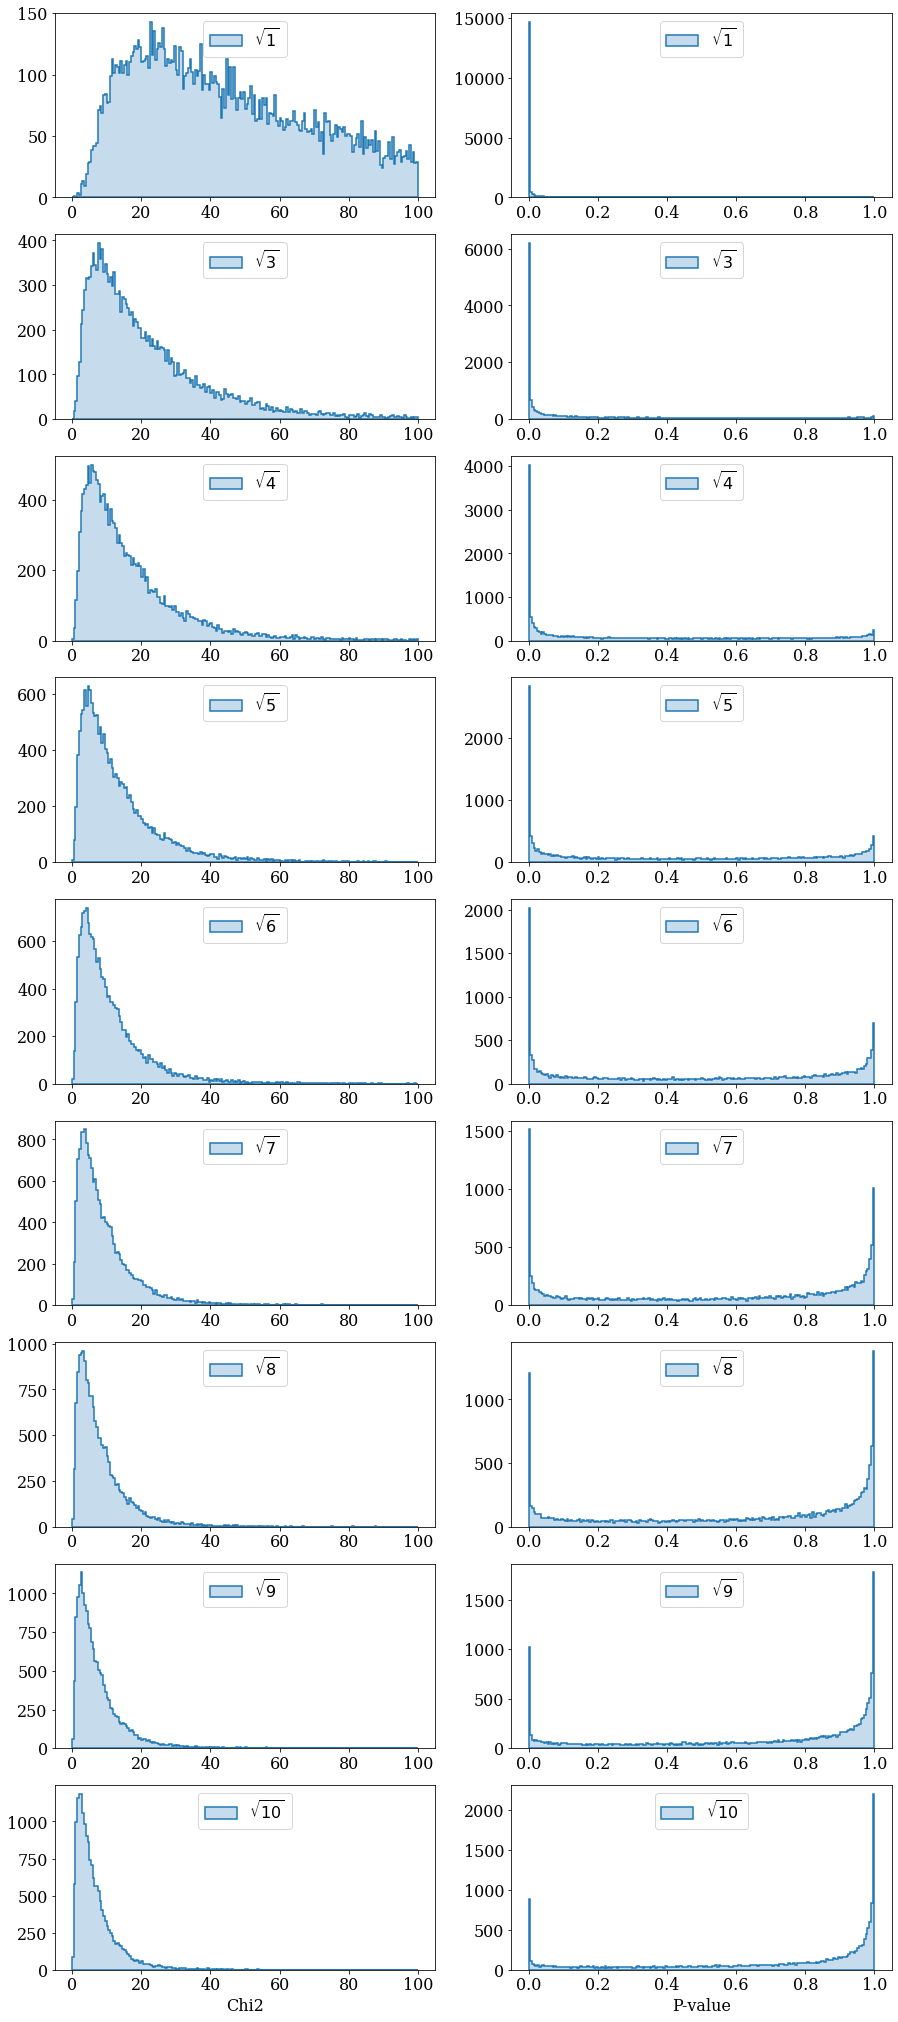

In [141]:

nbins = 200
chi2_range = (0, 100)
p_ranage = (0, 1)

fig, ax = plt.subplots(nrows = 9, ncols = 2, figsize=(15, 4*9))
ax_x = np.arange(9)
results = [results_1, results_2, results_4, results_5, results_6, results_7, results_8, results_9, results_3]
factor = [1, 3, 4, 5, 6, 7, 8, 9, 10]

for index, result in enumerate(results):
    s = "$\sqrt{" + str(factor[index]) + "}$"
    ax[index, 0].hist(result[0], bins=nbins, range=chi2_range, histtype="stepfilled", facecolor=colors.to_rgba('C0', 0.25), edgecolor="C0", lw=1.5, label=s);
    ax[index, 1].hist(result[1], bins=nbins, range=p_ranage, histtype="stepfilled", facecolor=colors.to_rgba('C0', 0.25), edgecolor="C0", lw=1.5, label=s);


# Set x labels for the last plots
ax[8, 0].set_xlabel("Chi2")
ax[8, 1].set_xlabel("P-value")

# Show legends on all plots
[x[0].legend(loc="upper center") for x in ax]
[x[1].legend(loc="upper center") for x in ax]


To have a good balance, where we can filter out the fits that give p ~ 0 and p ~ 1, perhaps sqrt(6) is better? TODO ask Troels. 